# Process and visualize the dust datasets

This notebook processes and visualizes the dust flux datasets, corresponding to empirical and simulated dust flux depositions for the Holocene and Last Glacial Maximum periods.

## Preliminaries

Import the necessary libraries and specify the data folders.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm, lognorm
import xarray as xr
from sklearn.preprocessing import StandardScaler
import geopandas as gpd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
FIGURE_PATH = "../Figures/"
DATA_PATH = "../Data/"
DATA_LOAD_PATH = DATA_PATH + "original_data/"
DATA_SAVE_PATH = DATA_PATH + "processed_data/"

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

## Processing functionality

The processing of the data involves standard normalization.

In [5]:
class Preprocess:
    def __init__(self, df, time_label=None):
        '''
        Create a preprocess class for the given dataframe.
        The time label correspond to the climate period in the ESM,
        with the label 0.1 corresponding to the Holocene and
        the label 21 to the Last Glacial Maximum.
        '''
        self.df = df.copy()
        self.time = time_label

    def preprocess_empirical_dataset(self):
        '''Clean up the dataset of empirical measurements.'''
        # Preprocess data headers
        self.df.rename(columns={"Longitude": "lon", "Latitude": "lat"}, inplace=True)
        self.df["dep"] = self.df["MAR"].values.astype(float)
        self.df.drop(["MAR", "LogMAR"], axis=1, inplace=True)
        # Convert data from kg/m^2/s to g/m^2/a
        self.df["dep"] = self.df["dep"].values * 1000 * 365 * 24 * 60 * 60
        # Drop all data that was included for the kriging analysis
        self.df = self.df[(self.df["lat"] > -90) & (self.df["lat"] < 90) &
                          (self.df["lon"] > -180) & (self.df["lon"] <= 180)]

    def preprocess_simulated_dataset(self):
        '''Clean up the dataset of ESM simulations.'''
        self.df.reset_index(inplace=True)
        # Select the correct time period
        if self.time.lower() == "holocene":
            self.df = self.df[np.isclose(self.df['time'], 0.1)]
        elif self.time.lower() == "lgm":
            self.df = self.df[np.isclose(self.df['time'], 21)]
        self.df.drop(["time", "load"], axis=1, inplace=True)
        # Change longitude range to (-180, 180)
        self.df.loc[self.df['lon'] > 180, 'lon'] = self.df['lon'] - 360

    def normalize_data(self):
        '''Normalize data based on z-score.'''
        self.df['log_dep'] = np.log10(self.df['dep'])
        self.df['log_dep_norm'] = StandardScaler().fit_transform(np.array(self.df['log_dep']).reshape(-1, 1))

Load visualization functions to generate the figures.

In [6]:
with open("functions_plot.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)

## Preprocess the datasets

Load the datasets:
1. The empirical data from [DIRTMAP: the geological record of dust](https://researchers.mq.edu.au/en/publications/dirtmap-the-geological-record-of-dust).
2. The ERA5 simulated data from [Paleodust variability since the Last Glacial Maximum and implications for iron inputs to the ocean](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2016GL067911).


In [7]:
df_empirical_Holocene_raw = pd.read_csv(DATA_LOAD_PATH+"MAR_HOL.csv")
df_empirical_LGM_raw = pd.read_csv(DATA_LOAD_PATH+"MAR_LGM.csv")
df_simulation_raw = xr.open_dataset(DATA_LOAD_PATH+"Albanietal2016_GRL_dust.nc").to_dataframe()

In [8]:
preprocessor_empirical_Holocene = Preprocess(df_empirical_Holocene_raw)
preprocessor_empirical_Holocene.preprocess_empirical_dataset()
preprocessor_empirical_Holocene.normalize_data()
df_empirical_Holocene = preprocessor_empirical_Holocene.df

preprocessor_empirical_LGM = Preprocess(df_empirical_LGM_raw)
preprocessor_empirical_LGM.preprocess_empirical_dataset()
preprocessor_empirical_LGM.normalize_data()
df_empirical_LGM = preprocessor_empirical_LGM.df

preprocessor_simulation_Holocene = Preprocess(df_simulation_raw, "Holocene")
preprocessor_simulation_Holocene.preprocess_simulated_dataset()
preprocessor_simulation_Holocene.normalize_data()
df_simulation_Holocene = preprocessor_simulation_Holocene.df

preprocessor_simulation_LGM = Preprocess(df_simulation_raw, "LGM")
preprocessor_simulation_LGM.preprocess_simulated_dataset()
preprocessor_simulation_LGM.normalize_data()
df_simulation_LGM = preprocessor_simulation_LGM.df

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

Also plot a log-normal fit of the empirical data.

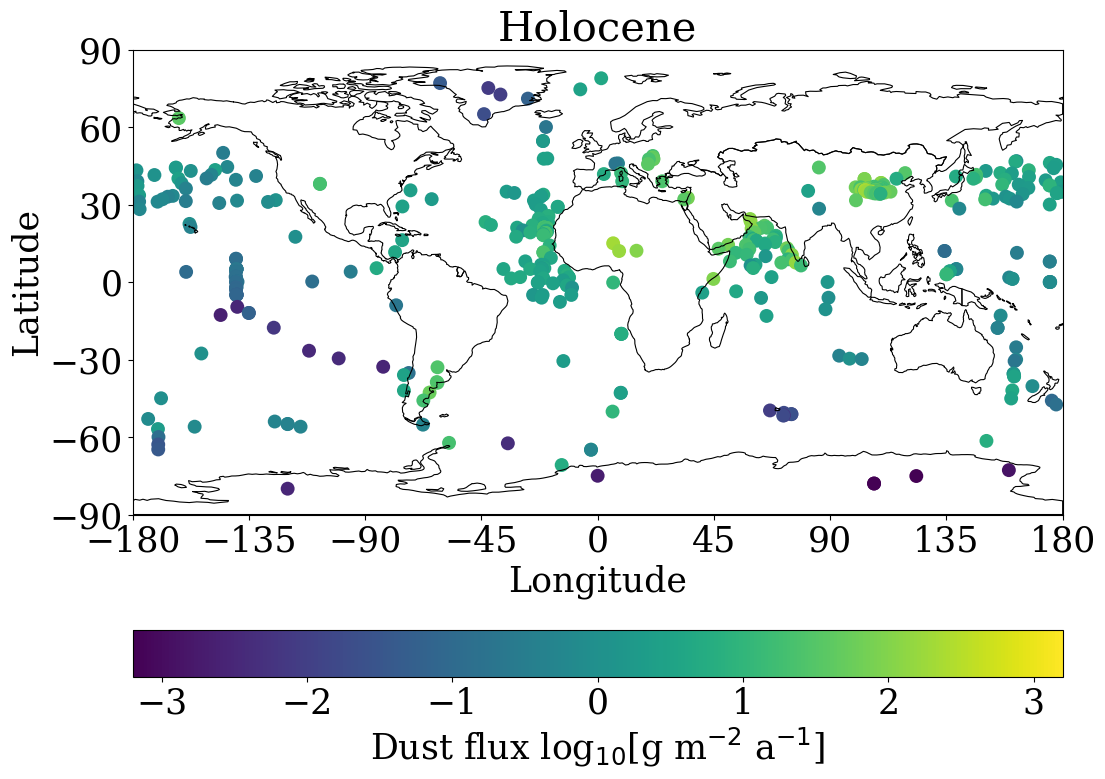

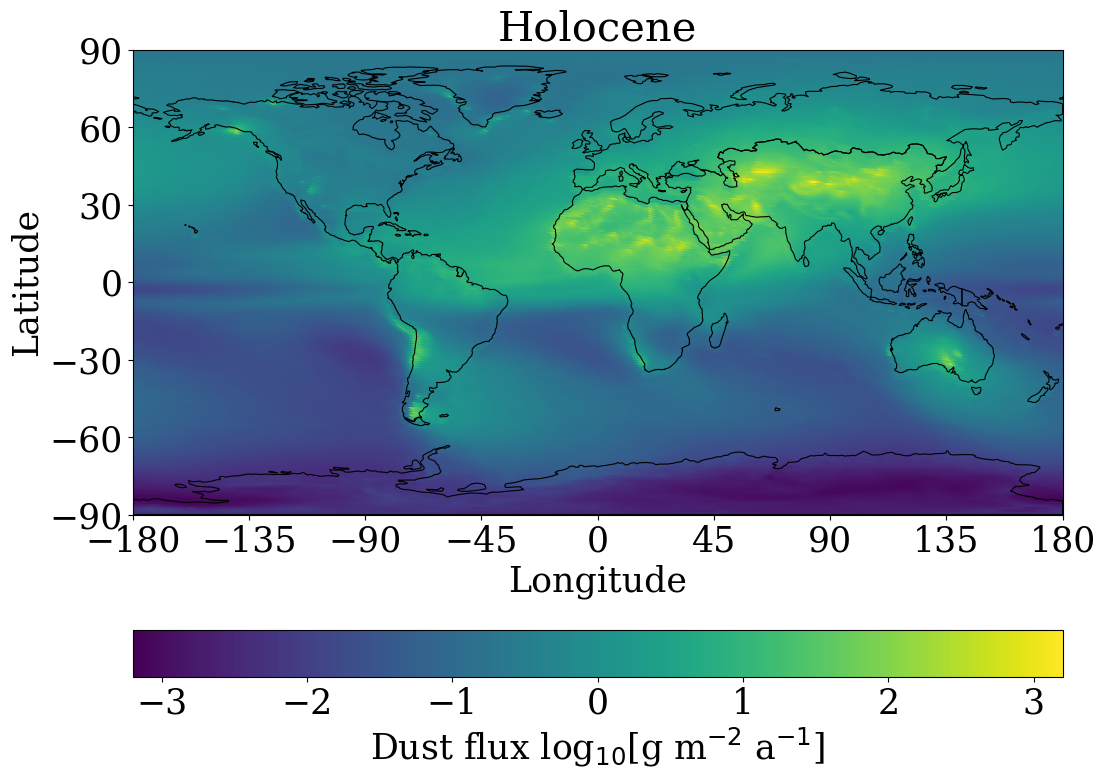

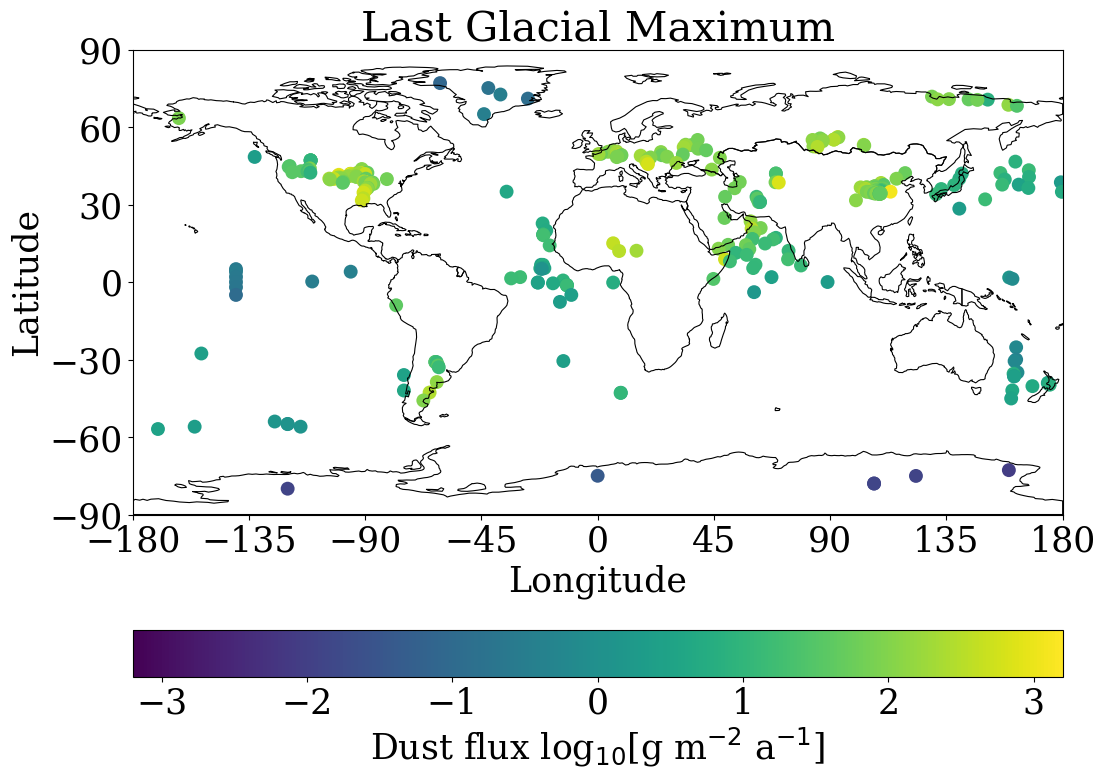

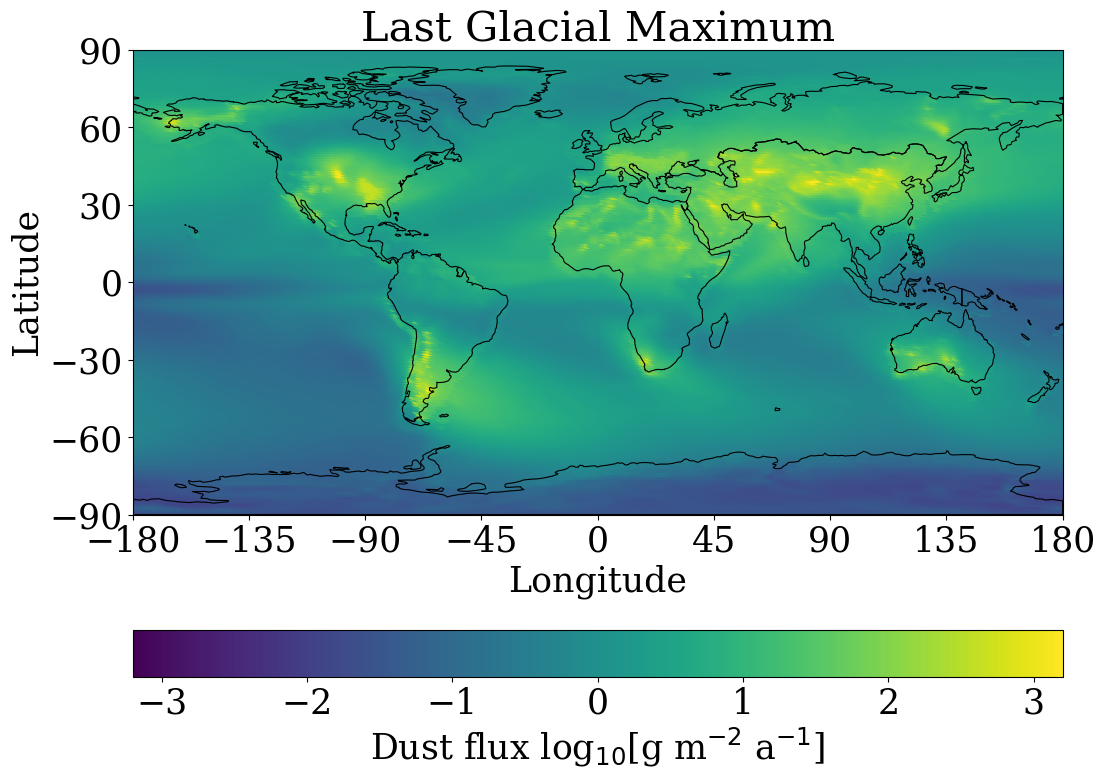

In [9]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_EMPIRICAL_HOLOCENE')

plot_dust_deposition_map(df=df_simulation_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_SIMULATED_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_EMPIRICAL_LGM')

plot_dust_deposition_map(df=df_simulation_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_SIMULATED_LGM')

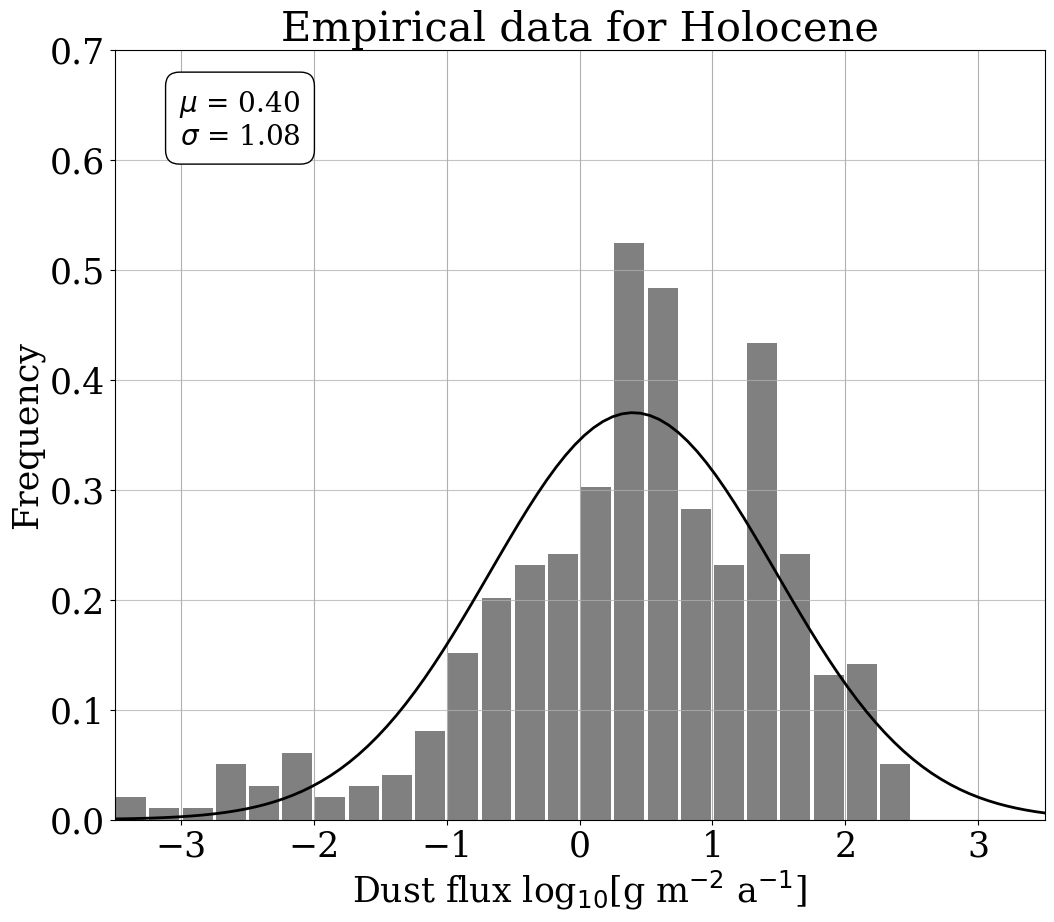

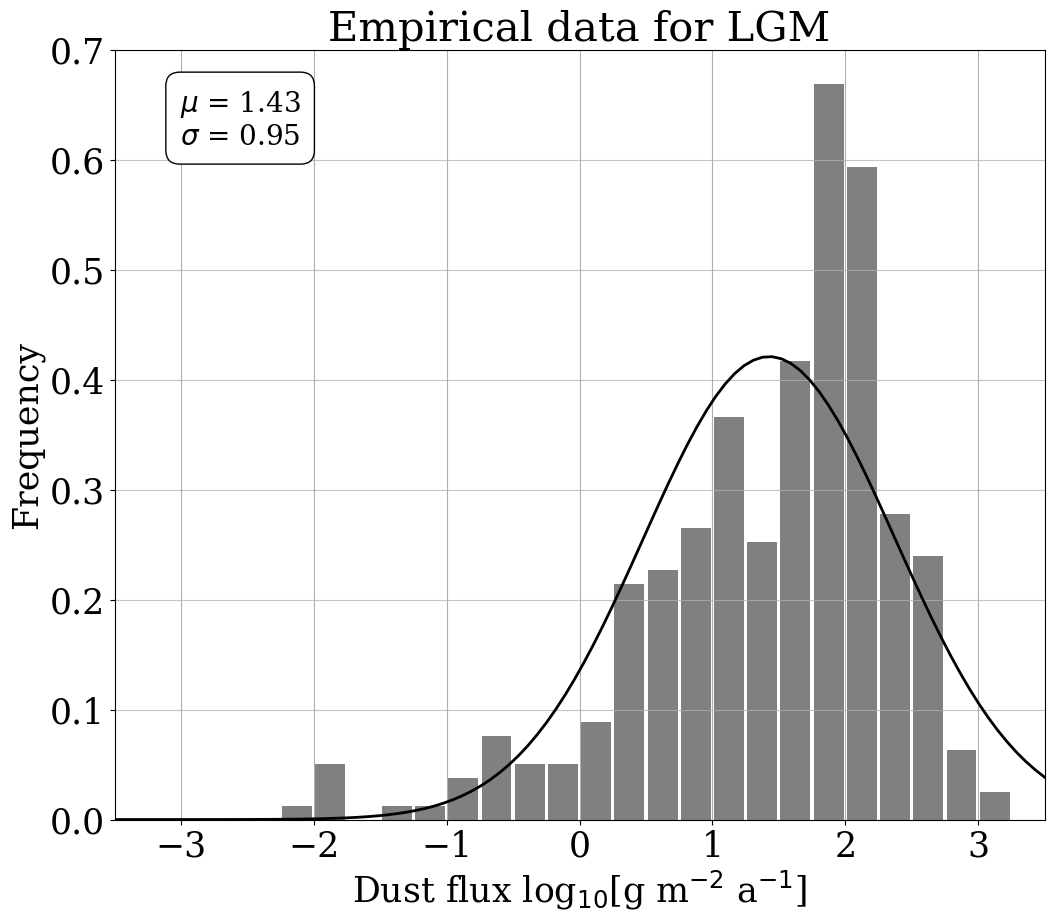

In [10]:
plot_hist(df=df_empirical_Holocene,
          title='Empirical data for Holocene',
          name_to_save='DATA_HIST_EMPIRICAL_HOLOCENE')

plot_hist(df=df_empirical_LGM,
          title='Empirical data for LGM',
          name_to_save='DATA_HIST_EMPIRICAL_LGM')

## Export the processed data

In [11]:
with open(DATA_SAVE_PATH + "df_empirical_Holocene.csv", 'w') as f:
    df_empirical_Holocene.to_csv(f, index=False)

with open(DATA_SAVE_PATH + "df_empirical_LGM.csv", 'w') as f:
    df_empirical_LGM.to_csv(f, index=False)

with open(DATA_SAVE_PATH + "df_simulation_Holocene.csv", 'w') as f:
    df_simulation_Holocene.to_csv(f, index=False)

with open(DATA_SAVE_PATH + "df_simulation_LGM.csv", 'w') as f:
    df_simulation_LGM.to_csv(f, index=False)